In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/b2/scratch/ahringer/jj374/lab/relmapping


In [2]:
# (Chen et al., 2013) TSSs -- load
def WS260_geneIDs():
    fp_geneIDs = lp('.wget/ftp.wormbase.org/pub/wormbase/releases/WS260/species/c_elegans/PRJNA13758/annotation/c_elegans.PRJNA13758.WS260.geneIDs.txt.gz')
    df_geneIDs = pd.read_csv(fp_geneIDs, sep=',', names=('na', 'gene_id', 'locus', 'sequence_id', 'status'))\
        [['gene_id', 'locus', 'sequence_id', 'status']]
    return df_geneIDs

def WS260_genes():
    df_genes = yp.read_wbgtf('WS260_ce10/WS260_ce10.genes.gtf.gz', parse_attr=False)
    df_genes = yp.df_gfftags_unpack(df_genes, 'attribute')
    df_genes = df_genes[list(yp.NAMES_GTF[:8]) + ['gene_id', 'gene_source', 'gene_biotype']]
    #print(len(df_genes), 'gene records')
    return df_genes

#WS260_geneIDs()
#WS260_genes()

fp_ = 'wget/genome.cshlp.org/content/suppl/2013/04/16/gr.153668.112.DC1/Supp_TableS2.csv'
df_ = pd.read_csv(fp_)
print('%d TICs in Supp_TableS2.csv' % (len(df_),))
df_ = df_.loc[(df_['assignment type'] == 'wormbase_tss') | (df_['assignment type'] == 'raft_to_wormbase_tss')]
print('%d number of wormbase_tss or raft_to_wormbase_tss TICs' % (len(df_),))
df_ = df_.query('mode_position == mode_position')
print('%d number of wormbase_tss or raft_to_wormbase_tss TICs with mode_position set' % (len(df_),))
df_ = df_.merge(WS260_geneIDs(), left_on='assigned gene name', right_on='sequence_id').query('status == "Live"')
print('%d marked as "Live" in WS260' % (len(df_),))
df_ = df_.merge(WS260_genes(), left_on='gene_id', right_on='gene_id').query('gene_biotype == "protein_coding"')
print('%d with biotype protein_coding' % (len(df_),))

df_chen = pd.DataFrame()
df_chen['chrom'] = 'chr' + df_['chr']
df_chen['start'] = list(map(lambda mode_position: int(mode_position) - 1, df_['mode_position']))
df_chen['end'] = df_chen['start'] + 1
df_chen['name'] = df_['assigned gene name']
df_chen['score'] = df_['tag count']
assert all(df_['strand_x'] == df_['strand_y'])
df_chen['strand'] = df_['strand_x']
df_chen = df_chen.sort_values(['chrom', 'start', 'end', 'start']).reset_index(drop=True)
print('%d in final, cleaned-up set' % (len(df_chen),))

fp_ = 'annot/Fig2S5_tss/Chen2013/Chen2013_tss.bed'
df_chen.to_csv(fp_, header=False, index=False, sep='\t')
!wc -l {fp_}

73500 TICs in Supp_TableS2.csv
12738 number of wormbase_tss or raft_to_wormbase_tss TICs
12737 number of wormbase_tss or raft_to_wormbase_tss TICs with mode_position set
12665 marked as "Live" in WS260


/mnt/home1/ahringer/jj374/relmapping/scripts/yarp/yarp.py:400: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_name = df_name.convert_objects(convert_numeric=True)


9995 with biotype protein_coding
9995 in final, cleaned-up set
9995 annot/Fig2S5_tss/Chen2013/Chen2013_tss.bed


coding_promoter          5157
pseudogene_promoter         4
unknown_promoter          164
\n\nputative_enhancer     687
\n\nnon-coding_RNA          8
other_element              43
Name: name, dtype: int64

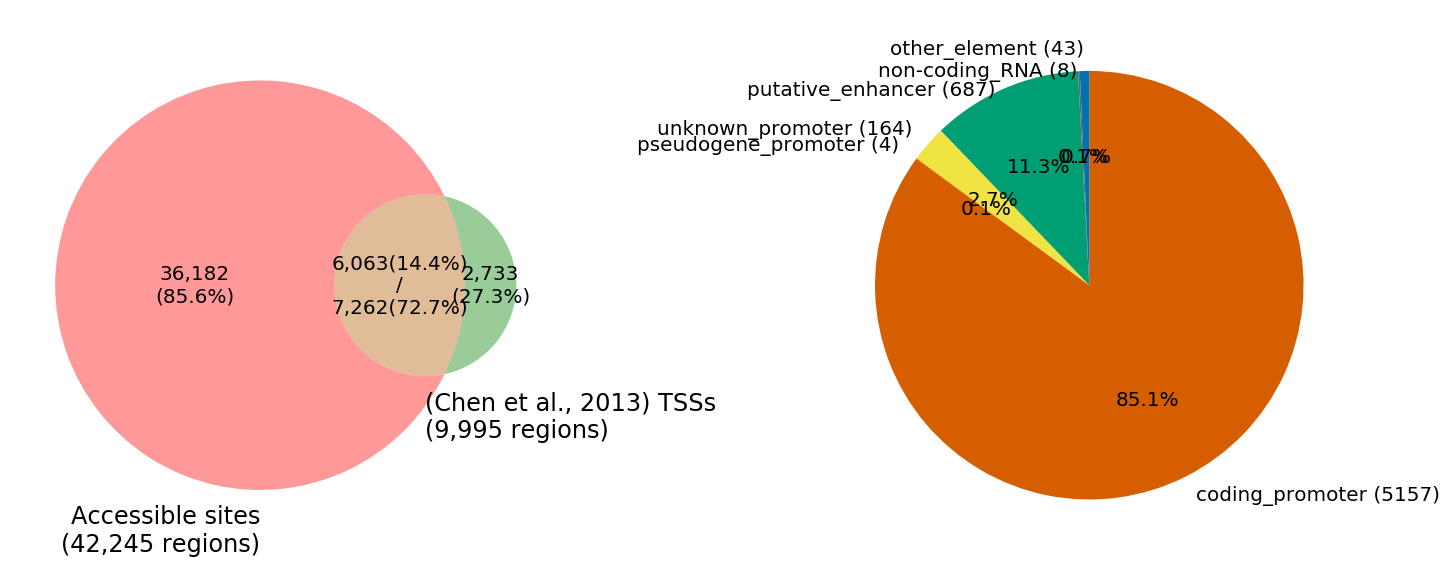

In [5]:
df_regl_ = regl_mode(flank_len=150)
df_regl_['annot'] = regl_()['annot']

# (Chen et al., 2013)
gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_regl_),
    BedTool.from_dataframe(df_chen[yp.NAMES_BED3]),
    label_a='Accessible sites',
    label_b='(Chen et al., 2013) TSSs',
)

plt.figure(figsize=(12,6)).subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
gv.plot()

plt.subplot(1,2,2)
annot_count_ = gv.df_a_with_b['name'].value_counts()[config['annot']]
annot_count_.index = [
    'coding_promoter',
    'pseudogene_promoter',
    'unknown_promoter',
    '\n\nputative_enhancer',
    '\n\nnon-coding_RNA',
    'other_element'
]
#plt.title('Annotation of %d accessible sites that overlap a TSS from (Chen et al., 2013)' % (len(gv.df_a_with_b),))
plt.pie(
    annot_count_.values,
    labels = ['%s (%d)' % (l, c) for l, c in annot_count_.iteritems()],
    colors=[yp.RED, yp.ORANGE, yp.YELLOW, yp.GREEN, '0.4', yp.BLUE],
    counterclock=False,
    startangle=90,
    autopct='%.1f%%',
);
plt.gca().set_aspect('equal')
plt.savefig('annot/Fig2S5_tss/Chen2013_annot.pdf', bbox_inches='tight', transparent=True)
annot_count_

In [4]:
# (Chen et al., 2013) TSSs now annotated as putative_enhancer
#fp_ = 'annot/FigC_TSS/overlaps_Chen2013_TSS_to_putative_enhancer.bed'
#gv.df_a_with_b.query('name == "putative_enhancer"').to_csv(fp_, header=False, sep='\t', index=False)
#!wc -l {fp_}